In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn.apionly as sns
import pymc3 as pm
import pandas

/Users/richardweiss/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
import pymc3 as pm
from pymc3.distributions.dist_math import bound, logpow, factln
from pymc3.distributions import draw_values, generate_samples
import theano.tensor as tt
import numpy as np
import scipy.stats.distributions

class ZTP(pm.Discrete):
    def __init__(self, mu, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mode = tt.minimum(tt.floor(mu).astype('int32'), 1)
        self.mu = mu = tt.as_tensor_variable(mu)

    def zpt_cdf(self, mu, size=None):
        mu = np.asarray(mu)
        dist = scipy.stats.distributions.poisson(mu)
        
        lower_cdf = dist.cdf(0)
        upper_cdf = 1
        nrm = upper_cdf - lower_cdf
        sample = np.random.random(size=size) * nrm + lower_cdf

        return dist.ppf(sample)
        
    def random(self, point=None, size=None, repeat=None):
        mu = draw_values([self.mu], point=point)
        return generate_samples(self.zpt_cdf, mu,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        mu = self.mu
        #              mu^k
        #     PDF = ------------
        #            k! (e^mu - 1)
        # log(PDF) = log(mu^k) - (log(k!) + log(e^mu - 1))
        #
        # See https://en.wikipedia.org/wiki/Zero-truncated_Poisson_distribution
        p = logpow(mu, value) - (factln(value) + pm.math.log(pm.math.exp(mu)-1))
        log_prob = bound(
            p,
            mu >= 0, value >= 0)
        # Return zero when mu and value are both zero
        return tt.switch(1 * tt.eq(mu, 0) * tt.eq(value, 0),
                         0, log_prob)

    

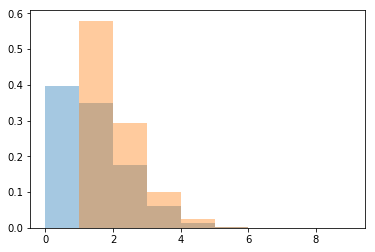

In [4]:
lam = 1
full_counts = np.random.poisson(lam, size=2000)
truncated_counts = full_counts[full_counts > 0]

sns.distplot(full_counts, bins=np.arange(10), kde=False, norm_hist=True)
sns.distplot(truncated_counts, bins=np.arange(10), kde=False, norm_hist=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:03<00:00, 1534.08it/s]


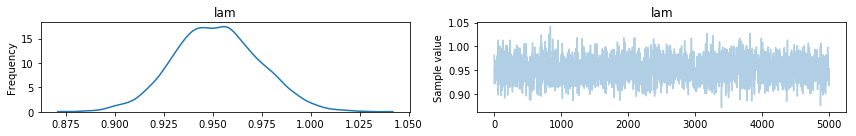

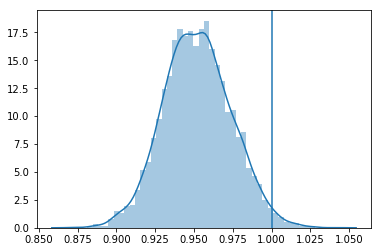

In [5]:
with pm.Model():
    lam = pm.HalfNormal('lam', 10)
    pm.Poisson('obs', mu=lam, observed=full_counts)
    
    trace = pm.sample(5000)
    pm.traceplot(trace)
    
plt.figure()
sns.distplot(trace.lam)
plt.axvline(1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 5451/5500 [00:03<00:00, 1672.37it/s]/Users/richardweiss/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.888260897012, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 5500/5500 [00:03<00:00, 1670.28it/s]


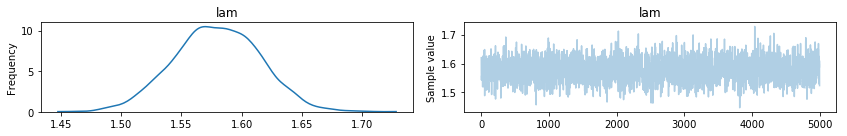

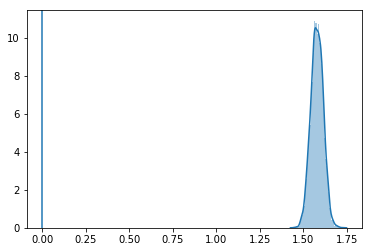

In [6]:
with pm.Model():
    lam = pm.HalfNormal('lam', 10)
    pm.Poisson('obs', mu=lam, observed=truncated_counts)
    
    trace = pm.sample(5000)
    pm.traceplot(trace)
    
plt.figure()
sns.distplot(trace.lam)
plt.axvline()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:04<00:00, 1229.72it/s]


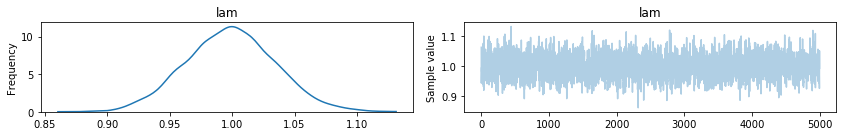

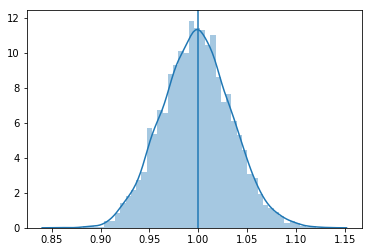

In [7]:
with pm.Model():
    lam = pm.HalfNormal('lam', 10, shape=1)
    ZTP('obs', mu=lam[np.zeros_like(truncated_counts)], observed=truncated_counts)
    
    trace = pm.sample(5000)
    pm.traceplot(trace)
    
plt.figure()
sns.distplot(trace.lam)
plt.axvline(1)

In [8]:
rng = np.random.RandomState(4353420)

lams = np.asarray([0.79, 0.95])
choices = rng.choice(2, size=4000)
full_counts = rng.poisson(lams[choices])
truncated_counts = full_counts[full_counts > 0]
truncated_choices = choices[full_counts > 0]
trunc_size = truncated_counts.size
colors = sns.color_palette(n_colors=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5000/5000 [00:02<00:00, 2473.14it/s]



lam:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.797            0.026            0.000            [0.747, 0.849]
  0.913            0.028            0.000            [0.856, 0.968]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.747          0.779          0.796          0.814          0.849
  0.858          0.894          0.913          0.932          0.970



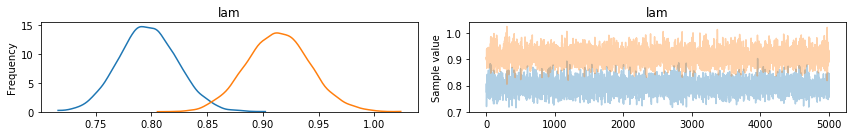

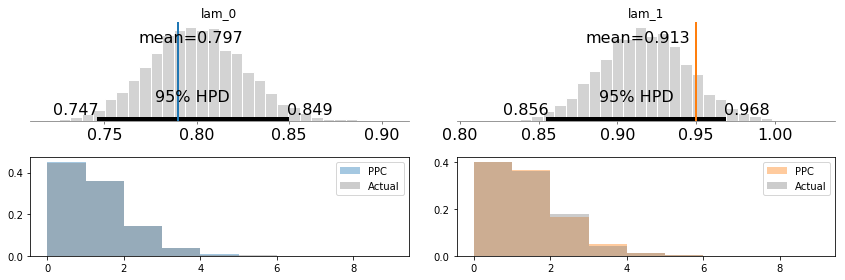

In [17]:
with pm.Model():
    lam = pm.HalfNormal('lam', 10, shape=2)
    # This is a weird way to pass mu here, 
    # but it's much faster. I blame my implementation :P
    pm.Poisson('obs', mu=lam[choices[:trunc_size]], observed=full_counts[:trunc_size])
    
    trace = pm.sample(5000)
    ppc = pm.sample_ppc(trace)
    pm.traceplot(trace)
    
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,4))
pm.plot_posterior(trace, color='lightgrey', ax=axs[0, :])
axs[0, 0].axvline(lams[0], color=colors[0], linewidth=2)
axs[0, 1].axvline(lams[1], color=colors[1], linewidth=2)
dist_1 = ppc['obs'][:, choices[:trunc_size] == 0].ravel()
dist_2 = ppc['obs'][:, choices[:trunc_size] == 1].ravel()
true_1 = full_counts[:trunc_size][choices[:trunc_size] == 0]
true_2 = full_counts[:trunc_size][choices[:trunc_size] == 1]
sns.distplot(dist_1, ax=axs[1, 0], norm_hist=True, kde=False, bins=np.arange(10), label='PPC', color=colors[0])
sns.distplot(true_1, ax=axs[1, 0], norm_hist=True, kde=False, bins=np.arange(10), label='Actual', color='grey')
sns.distplot(dist_2, ax=axs[1, 1], norm_hist=True, kde=False, bins=np.arange(10), label='PPC', color=colors[1])
sns.distplot(true_2, ax=axs[1, 1], norm_hist=True, kde=False, bins=np.arange(10), label='Actual', color='grey')
axs[1, 1].legend()
axs[1, 0].legend()

plt.savefig('truncated-zpt-easy.png')
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5000/5000 [00:40<00:00, 124.52it/s]



lam:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.789            0.034            0.000            [0.724, 0.853]
  0.949            0.034            0.000            [0.880, 1.013]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.725          0.766          0.788          0.812          0.854
  0.883          0.926          0.949          0.972          1.017



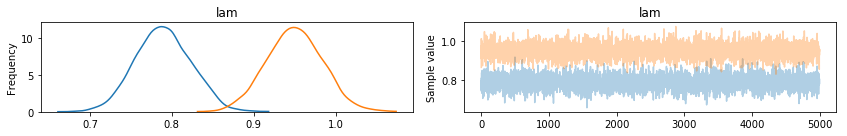

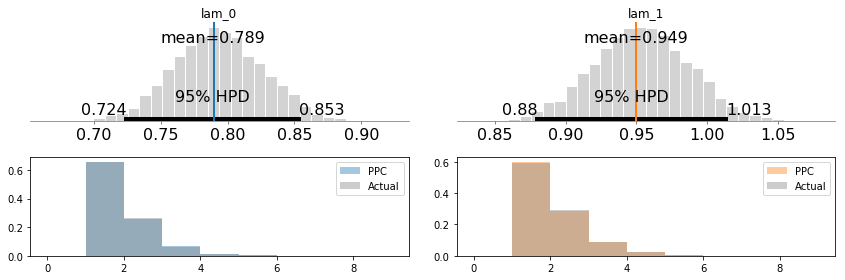

In [16]:
with pm.Model():
    lam = pm.HalfNormal('lam', 10, shape=2)
    ZTP('obs', mu=lam[truncated_choices], observed=truncated_counts)
    
    trace = pm.sample(5000)
    ppc = pm.sample_ppc(trace)
    pm.traceplot(trace)
    

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,4))
pm.plot_posterior(trace, color='lightgrey', ax=axs[0, :])
axs[0, 0].axvline(lams[0], color=colors[0], linewidth=2)
axs[0, 1].axvline(lams[1], color=colors[1], linewidth=2)
dist_1 = ppc['obs'].squeeze()[:, truncated_choices == 0].ravel()
dist_2 = ppc['obs'].squeeze()[:, truncated_choices == 1].ravel()
true_1 = truncated_counts[truncated_choices == 0]
true_2 = truncated_counts[truncated_choices == 1]
sns.distplot(dist_1, ax=axs[1, 0], norm_hist=True, kde=False, bins=np.arange(10), label='PPC', color=colors[0])
sns.distplot(true_1, ax=axs[1, 0], norm_hist=True, kde=False, bins=np.arange(10), label='Actual', color='grey')
sns.distplot(dist_2, ax=axs[1, 1], norm_hist=True, kde=False, bins=np.arange(10), label='PPC', color=colors[1])
sns.distplot(true_2, ax=axs[1, 1], norm_hist=True, kde=False, bins=np.arange(10), label='Actual', color='grey')
axs[1, 1].legend()
axs[1, 0].legend()
plt.savefig('truncated-zpt-clever.png')

pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5000/5000 [00:02<00:00, 2152.59it/s]



lam:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.446            0.036            0.000            [1.379, 1.517]
  1.548            0.037            0.000            [1.472, 1.617]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.377          1.422          1.446          1.471          1.516
  1.476          1.523          1.548          1.573          1.622



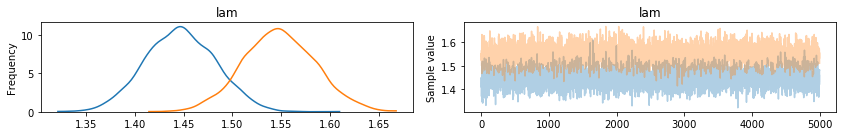

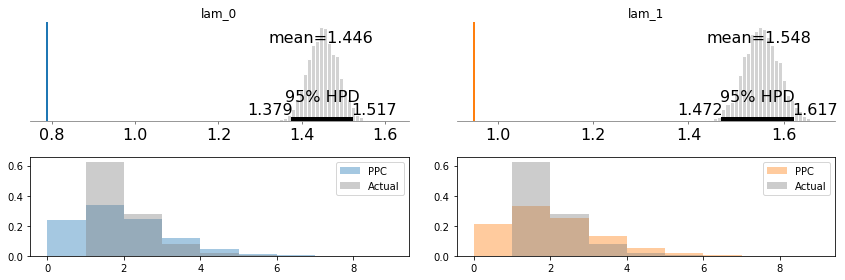

In [15]:
with pm.Model():
    lam = pm.HalfNormal('lam', 10, shape=2)
    pm.Poisson('obs', mu=lam[truncated_choices], observed=truncated_counts)
    
    trace = pm.sample(5000)
    ppc = pm.sample_ppc(trace)
    pm.traceplot(trace)
    
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,4))
pm.plot_posterior(trace, color='lightgrey', ax=axs[0, :])
axs[0, 0].axvline(lams[0], color=colors[0], linewidth=2)
axs[0, 1].axvline(lams[1], color=colors[1], linewidth=2)
dist_1 = ppc['obs'][:, truncated_choices == 0].ravel()
dist_2 = ppc['obs'][:, truncated_choices == 1].ravel()
true_1 = truncated_counts
true_2 = truncated_counts
sns.distplot(dist_1, ax=axs[1, 0], norm_hist=True, kde=False, bins=np.arange(10), label='PPC', color=colors[0])
sns.distplot(true_1, ax=axs[1, 0], norm_hist=True, kde=False, bins=np.arange(10), label='Actual', color='grey')
sns.distplot(dist_2, ax=axs[1, 1], norm_hist=True, kde=False, bins=np.arange(10), label='PPC', color=colors[1])
sns.distplot(true_2, ax=axs[1, 1], norm_hist=True, kde=False, bins=np.arange(10), label='Actual', color='grey')
axs[1, 1].legend()
axs[1, 0].legend()

plt.savefig('truncated-zpt-dumb.png')
pm.summary(trace)